In [9]:
!pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl (3.0 MB)
  Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.63.0-cp311-cp311-win_amd64.whl (3.9 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached ml_dtypes-0.4.0-cp311-cp311-win_amd64.whl (126 kB)
  Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl (46.2 MB)
  Using cached google_auth-2.29.0-py2.py3-none-any.whl (189 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cac

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\New folder\\Pavan Sai\\Data Science\\OpenCV\\Face Detection\\.facedetection\\Lib\\site-packages\\tensorboard\\backend\\application.py'
Check the permissions.


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install torch==2.0.0

     -------------------------------------- 172.3/172.3 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 5.7/5.7 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 133.3/133.3 kB 4.0 MB/s eta 0:00:00
  Using cached MarkupSafe-2.1.5-cp311-cp311-win_amd64.whl (17 kB)
     -------------------------------------- 536.2/536.2 kB 4.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install numpy

     ---------------------------------------- 15.8/15.8 MB 4.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.image_paths.append((os.path.join(cls_path, img_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\train", transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [2]:
import torch.nn as nn
from einops.layers.torch import Rearrange

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size

        self.patch_to_embedding = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d h w -> b (h w) d')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout),
            depth
        )

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.patch_to_embedding(x)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

model = VisionTransformer(
    image_size=224,
    patch_size=16,
    num_classes=len(dataset.classes),
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    channels=3,
    dropout=0.1
)


d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [3]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "vision_transformer_custom_dataset.pth")



Epoch [1/5], Loss: 0.7331, Accuracy: 50.82%
Epoch [2/5], Loss: 0.7036, Accuracy: 50.68%
Epoch [3/5], Loss: 0.7005, Accuracy: 49.91%
Epoch [4/5], Loss: 0.7018, Accuracy: 50.05%
Epoch [5/5], Loss: 0.7006, Accuracy: 49.14%


d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Classification Report:
               precision    recall  f1-score   support

      Female       0.50      1.00      0.67        40
        Male       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



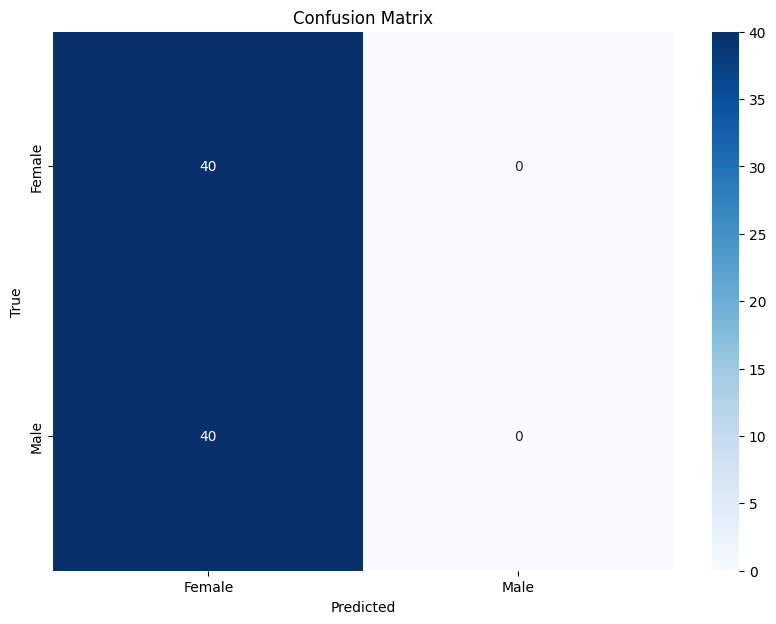

In [8]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model and print classification report and confusion matrix
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a test dataset
test_dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model
model.load_state_dict(torch.load("vision_transformer_custom_dataset.pth"))

# Evaluate the model
evaluate_model(model, test_loader, device)


In [11]:
## Check the dataset balanced or not 

from collections import Counter

train_class_counts = Counter([label for _, label in dataset])
print("Training class distribution:", train_class_counts)

val_class_counts = Counter([label for _, label in test_dataset])
print("Validation class distribution:", val_class_counts)


Training class distribution: Counter({0: 1100, 1: 1100})
Validation class distribution: Counter({0: 40, 1: 40})


In [8]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import Counter

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.image_paths.append((os.path.join(cls_path, img_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\train", transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check class distribution
#labels = [label for _, label in train_dataset]
#class_counts = Counter(labels)
#print("Class distribution:", class_counts)
#plt.bar(class_counts.keys(), class_counts.values())
#plt.xlabel('Class')
#plt.ylabel('Number of samples')
#plt.title('Class distribution in training dataset')
#plt.show()

# Load pre-trained ViT model and modify for your dataset
num_classes = len(dataset.classes)
model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model.to(device)

# Optional: Freeze layers
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with diagnostics
num_epochs = 3
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    #if val_accuracy > best_accuracy:
        #best_accuracy = val_accuracy
        #torch.save(model.state_dict(), "best_vit_model.pth")
        #print("Model saved!")

print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


Epoch [1/3], Loss: 0.8095, Training Accuracy: 53.64%
Validation Accuracy: 65.45%
Epoch [2/3], Loss: 0.4878, Training Accuracy: 76.53%
Validation Accuracy: 80.68%
Epoch [3/3], Loss: 0.3651, Training Accuracy: 84.94%
Validation Accuracy: 86.82%
Best Validation Accuracy: 0.00%


Classification Report:
               precision    recall  f1-score   support

      Female       0.90      0.88      0.89        40
        Male       0.88      0.90      0.89        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



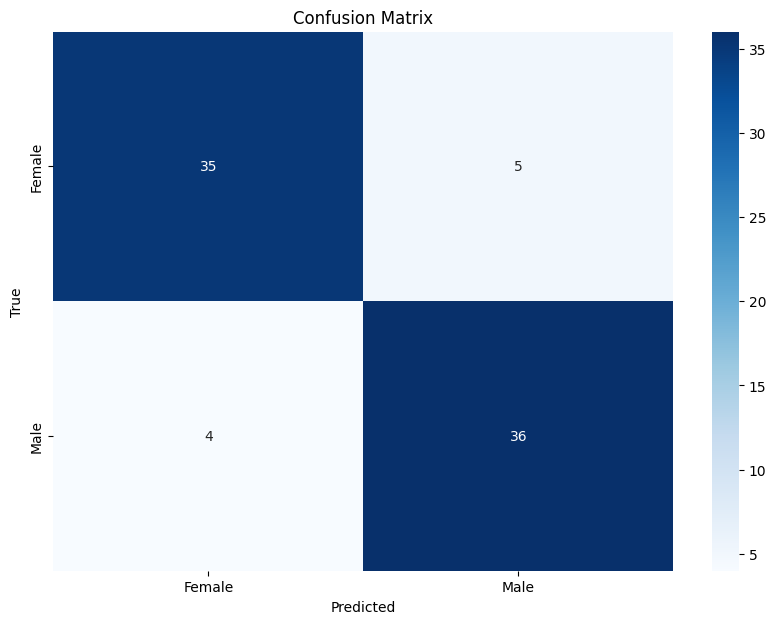

In [11]:
test1_dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\test", transform=transform)

test_loader = DataLoader(test1_dataset, batch_size=32, shuffle=False)
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load the best model and evaluate it

evaluate_model(model, test_loader, device)


In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from collections import Counter

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_path):
                self.image_paths.append((os.path.join(cls_path, img_name), self.class_to_idx[cls_name]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\Images_aug\Training", transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check class distribution
#labels = [label for _, label in train_dataset]
#class_counts = Counter(labels)
#print("Class distribution:", class_counts)
#plt.bar(class_counts.keys(), class_counts.values())
#plt.xlabel('Class')
#plt.ylabel('Number of samples')
#plt.title('Class distribution in training dataset')
#plt.show()

# Load pre-trained ViT model and modify for your dataset
num_classes = len(dataset.classes)
model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model.to(device)

# Optional: Freeze layers
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-1)

d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VIT Transformer on dataset2 around 3000 images 

In [2]:


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-1)

# Training loop with diagnostics
num_epochs = 4
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    
    # Validation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_vit_model_dataset2.pth")
        print("Model saved!")

print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


Epoch [1/4], Loss: 3.6118, Training Accuracy: 91.54%
Validation Accuracy: 92.88%
Model saved!
Epoch [2/4], Loss: 2.2760, Training Accuracy: 94.10%
Validation Accuracy: 93.84%
Model saved!
Epoch [3/4], Loss: 1.9897, Training Accuracy: 95.18%
Validation Accuracy: 94.40%
Model saved!
Epoch [4/4], Loss: 1.7932, Training Accuracy: 95.80%
Validation Accuracy: 93.44%
Best Validation Accuracy: 94.40%


Testing Accuracy: 93.44%
Classification Report:
               precision    recall  f1-score   support

      female       0.79      0.95      0.86      1100
        male       0.94      0.74      0.83      1100

    accuracy                           0.85      2200
   macro avg       0.86      0.85      0.84      2200
weighted avg       0.86      0.85      0.84      2200



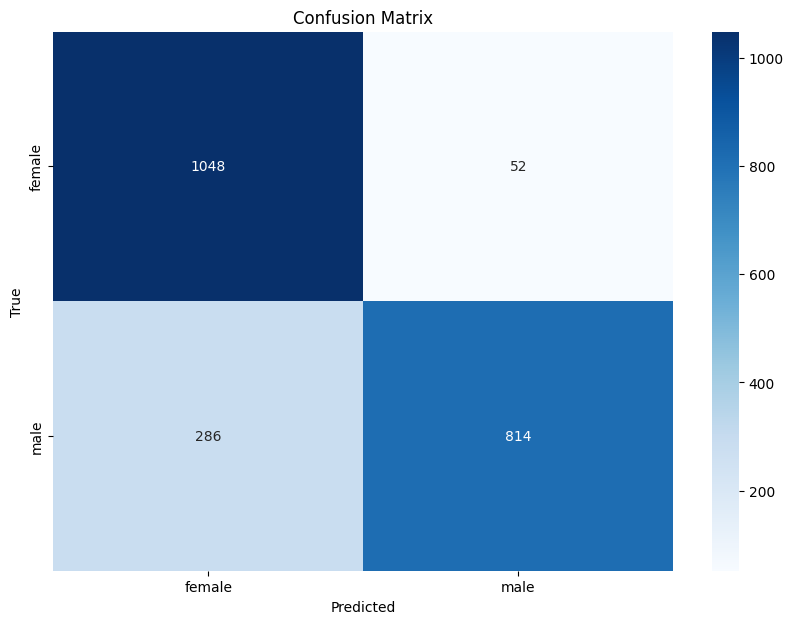

In [3]:
test2_dataset = CustomDataset(root_dir=r"D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\train", transform=transform)

test1_loader = DataLoader(test2_dataset, batch_size=32, shuffle=False)
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_accuracy = 100 * correct / total
    print(f"Testing Accuracy: {test_accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load the best model and evaluate it

evaluate_model(model, test1_loader, device)


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from timm import create_model

# Load the model
model = create_model('vit_base_patch16_224', pretrained=False)
num_classes = 2  # Update this to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)
model.load_state_dict(torch.load("best_vit_model_dataset2.pth"))
model.to(device)
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the class of an image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()

# Example usage
image_path = ""
predicted_class = predict_image(image_path)
print(f"Predicted class: {predicted_class}")


In [1]:
!pip install mediapipe

     ---------------------------------------- 50.8/50.8 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 51.5/51.5 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 45.3/45.3 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 200.1/200.1 kB 3.0 MB/s eta 0:00:00
     -------------------------------------- 181.5/181.5 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 117.6/117.6 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
#Using  Mediapipe detect the face in image and crop the face part only 

import os
import cv2 
import mediapipe as mp

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Directory containing images
image_dir = r'D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\archive\test\Female'
cropped_face_dir = r'D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\Images_aug\Training\female'

if not os.path.exists(cropped_face_dir):
    os.makedirs(cropped_face_dir)

# Iterate over all files in the directory
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image at {image_path}")
        continue

    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize Face Detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Perform face detection
        results = face_detection.process(image_rgb)
        
        if results.detections:
            for detection in results.detections:
                # Get bounding box of the detected face
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                
                # Ensure the bounding box coordinates are within image dimensions
                if x < 0: x = 0
                if y < 0: y = 0
                if x + w > iw: w = iw - x
                if y + h > ih: h = ih - y
                
                # Debug information
                print(f"Image: {image_file}, Bounding Box: x={x}, y={y}, w={w}, h={h}")

                # Crop the face from the image
                cropped_face = image[y:y+h, x:x+w]

                if cropped_face.size == 0:
                    print(f"Failed to crop face from image: {image_file}")
                    continue

                # Generate unique filename
                cropped_face_filename = f'cropped_face_{os.path.splitext(image_file)[0]}.jpg'
                cropped_face_path = os.path.join(cropped_face_dir, cropped_face_filename)
                
                # Save the cropped face image
                cv2.imwrite(cropped_face_path, cropped_face)

                # Optionally, display the cropped face
                # cv2.imshow('Cropped Face', cropped_face)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()

print("Faces cropped and saved successfully.")


Image: 110.jpg, Bounding Box: x=1182, y=1740, w=2370, h=2370
Image: 111.jpg, Bounding Box: x=461, y=1211, w=995, h=1091
Image: 112.jpg, Bounding Box: x=547, y=846, w=1230, h=1230
Image: 113.jpg, Bounding Box: x=796, y=1636, w=1669, h=1668
Image: 114.jpg, Bounding Box: x=601, y=1287, w=2547, h=2547
Image: 115.jpg, Bounding Box: x=859, y=2374, w=2766, h=2767
Image: 116.jpg, Bounding Box: x=710, y=1307, w=2977, h=2977
Image: 117.jpg, Bounding Box: x=608, y=885, w=1270, h=1270
Image: 118.jpg, Bounding Box: x=212, y=1237, w=1668, h=1668
Image: 119.jpg, Bounding Box: x=429, y=941, w=1807, h=1807
Image: 120.jpg, Bounding Box: x=270, y=674, w=702, h=702
Image: 121.jpg, Bounding Box: x=559, y=486, w=1023, h=1023
Image: 122.jpg, Bounding Box: x=109, y=413, w=1277, h=1277
Image: 123.jpg, Bounding Box: x=939, y=1163, w=1932, h=1932
Image: 124.jpg, Bounding Box: x=1685, y=2618, w=1644, h=1644
Image: 125.jpg, Bounding Box: x=158, y=247, w=424, h=424
Image: 126.jpg, Bounding Box: x=234, y=465, w=531,

In [15]:
import os
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from timm import create_model

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Vision Transformer model
model = create_model('vit_base_patch16_224', pretrained=False)
num_classes = 2  # Update this to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)
model.load_state_dict(torch.load("best_vit_model_dataset2.pth", map_location=device))
model.to(device)
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the class of an image tensor
def predict_image_tensor(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()

# Directory containing images
image_dir = r'D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\Images_aug\Validation'

# Iterate over all files in the directory
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image at {image_path}")
        continue

    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize Face Detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Perform face detection
        results = face_detection.process(image_rgb)
        
        if results.detections:
            for detection in results.detections:
                # Get bounding box of the detected face
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                
                # Ensure the bounding box coordinates are within image dimensions
                if x < 0: x = 0
                if y < 0: y = 0
                if x + w > iw: w = iw - x
                if y + h > ih: h = ih - y
                
                # Crop the face from the image
                cropped_face = image[y:y+h, x:x+w]
                
                if cropped_face.size == 0:
                    print(f"Failed to crop face from image: {image_file}")
                    continue

                # Convert cropped face to PIL image
                cropped_face_pil = Image.fromarray(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
                
                # Apply transformation
                cropped_face_tensor = transform(cropped_face_pil)
                
                # Predict the class of the cropped face
                predicted_class = predict_image_tensor(cropped_face_tensor)
                print(f"Image: {image_file}, Predicted class: {predicted_class}")

print("Faces cropped and classified successfully.")


Image: 0.jpg, Predicted class: 1
Image: 1.jpg, Predicted class: 1
Image: 10.jpg, Predicted class: 1
Image: 100.jpg, Predicted class: 1
Image: 101.jpg, Predicted class: 1
Image: 102.jpg, Predicted class: 1
Image: 103.jpg, Predicted class: 1
Image: 104.jpg, Predicted class: 1
Image: 105.jpg, Predicted class: 1
Image: 106.jpg, Predicted class: 1
Image: 107.jpg, Predicted class: 1
Image: 108.jpg, Predicted class: 1
Image: 109.jpg, Predicted class: 1
Image: 11.jpg, Predicted class: 1
Image: 12.jpg, Predicted class: 1
Image: 13.jpg, Predicted class: 0
Image: 14.jpg, Predicted class: 1
Image: 15.jpg, Predicted class: 1
Image: 16.jpg, Predicted class: 1
Image: 17.jpg, Predicted class: 1
Image: 18.jpg, Predicted class: 1
Image: 19.jpg, Predicted class: 1
Image: 2.jpg, Predicted class: 1
Image: 21.jpg, Predicted class: 1
Image: 22.jpg, Predicted class: 1
Image: 23.jpg, Predicted class: 1
Image: 24.jpg, Predicted class: 1
Image: 25.jpg, Predicted class: 1
Image: 26.jpg, Predicted class: 1
Image: 

In [18]:
# This code is to check the 

import os
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from timm import create_model
from sklearn.metrics import classification_report, accuracy_score

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Vision Transformer model
model = create_model('vit_base_patch16_224', pretrained=False)
num_classes = 2  # Update this to match the number of classes
model.head = nn.Linear(model.head.in_features, num_classes)
model.load_state_dict(torch.load("best_vit_model_dataset2.pth", map_location=device))
model.to(device)
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the class of an image tensor
def predict_image_tensor(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()

# Directory containing images
image_dir = r'D:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\Images_aug\Validation\male'
true_labels = []  # List to store true labels
predicted_labels = []  # List to store predicted labels

# Function to extract true label from the filename or directory structure
# Modify this function based on how your true labels are encoded in the filenames or directory structure
def get_true_label(image_file):
    # Example: Assuming the directory name is the label
    label = os.path.basename(os.path.dirname(image_file))
    return 0 if label == 'men' else 1  # Replace with actual label extraction logic

# Iterate over all files in the directory
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image at {image_path}")
        continue

    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize Face Detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Perform face detection
        results = face_detection.process(image_rgb)
        
        if results.detections:
            for detection in results.detections:
                # Get bounding box of the detected face
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                
                # Ensure the bounding box coordinates are within image dimensions
                if x < 0: x = 0
                if y < 0: y = 0
                if x + w > iw: w = iw - x
                if y + h > ih: h = ih - y
                
                # Crop the face from the image
                cropped_face = image[y:y+h, x:x+w]
                
                if cropped_face.size == 0:
                    print(f"Failed to crop face from image: {image_file}")
                    continue

                # Convert cropped face to PIL image
                cropped_face_pil = Image.fromarray(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
                
                # Apply transformation
                cropped_face_tensor = transform(cropped_face_pil)
                
                # Predict the class of the cropped face
                predicted_class = predict_image_tensor(cropped_face_tensor)
                predicted_labels.append(predicted_class)
                
                # Extract true label
                true_label = get_true_label(image_path)
                true_labels.append(true_label)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=['Male', 'Female'])
print(report)

cm = confusion_matrix(true_label, predicted_labels)
print(cm)


d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Accuracy: 0.9635258358662614
              precision    recall  f1-score   support

        Male       0.00      0.00      0.00         0
      Female       1.00      0.96      0.98       329

    accuracy                           0.96       329
   macro avg       0.50      0.48      0.49       329
weighted avg       1.00      0.96      0.98       329



d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\New folder\Pavan Sai\Data Science\OpenCV\Face Detection\.facedetection\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 1 instead.